In [64]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np # linear algebra
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import math
from datetime import datetime, date
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
import datetime as dt

print("Setup Complete")

Setup Complete


In [65]:
#모델불러오기
dam = pd.read_csv('보령댐_시간별.csv', encoding= 'cp949', thousands=',')
dam.head()

,일시,댐수위(ELm),강우량(mm),유입량(㎡/sec),총방류량(㎡/sec),저수량(백만㎥/sec),저수율(%)
0,2015-01-01 01시,66.12,0.0,2.6,2.6,53.0,45.3
1,2015-01-01 02시,66.12,0.0,3.0,3.0,53.0,45.3
2,2015-01-01 03시,66.12,0.0,3.1,3.1,53.0,45.3
3,2015-01-01 04시,66.12,0.0,3.0,3.0,53.0,45.3
4,2015-01-01 05시,66.12,0.0,2.9,2.9,53.0,45.3


In [66]:
dam.columns = ['date', 'water_level', 'rainfall', 'inflow', 'outflow', 'storage', 'storage_rate']
dam.head()

,date,water_level,rainfall,inflow,outflow,storage,storage_rate
0,2015-01-01 01시,66.12,0.0,2.6,2.6,53.0,45.3
1,2015-01-01 02시,66.12,0.0,3.0,3.0,53.0,45.3
2,2015-01-01 03시,66.12,0.0,3.1,3.1,53.0,45.3
3,2015-01-01 04시,66.12,0.0,3.0,3.0,53.0,45.3
4,2015-01-01 05시,66.12,0.0,2.9,2.9,53.0,45.3


In [67]:
#결측값 확인
print(dam.isnull().sum())

date            0
water_level     0
rainfall        8
inflow          0
outflow         0
storage         0
storage_rate    0
dtype: int64


In [68]:
dam=dam.interpolate()

In [69]:
#숫자로 변환 (필요할 경우 사용)
dam['inflow'] = pd.to_numeric(dam['inflow'],errors='coerce')

In [70]:
dam.describe()

,water_level,rainfall,inflow,outflow,storage,storage_rate
count,74937.000000,74937.000000,74937.000000,74937.000000,74937.000000,74937.000000
mean,63.834850,0.156070,4.809672,3.879728,44.492453,38.064314
std,4.467609,1.159574,19.230348,12.237647,17.338853,14.832148
min,52.160000,0.000000,0.000000,0.000000,9.690000,8.300000
25%,61.080000,0.000000,2.000000,2.700000,32.850000,28.100000
50%,63.130000,0.000000,2.800000,3.100000,40.300000,34.500000
75%,65.910000,0.000000,3.300000,3.400000,51.890000,44.400000
max,74.510000,59.400000,1208.200000,648.800000,91.060000,77.900000


In [71]:
dam = dam.reset_index(drop=True)

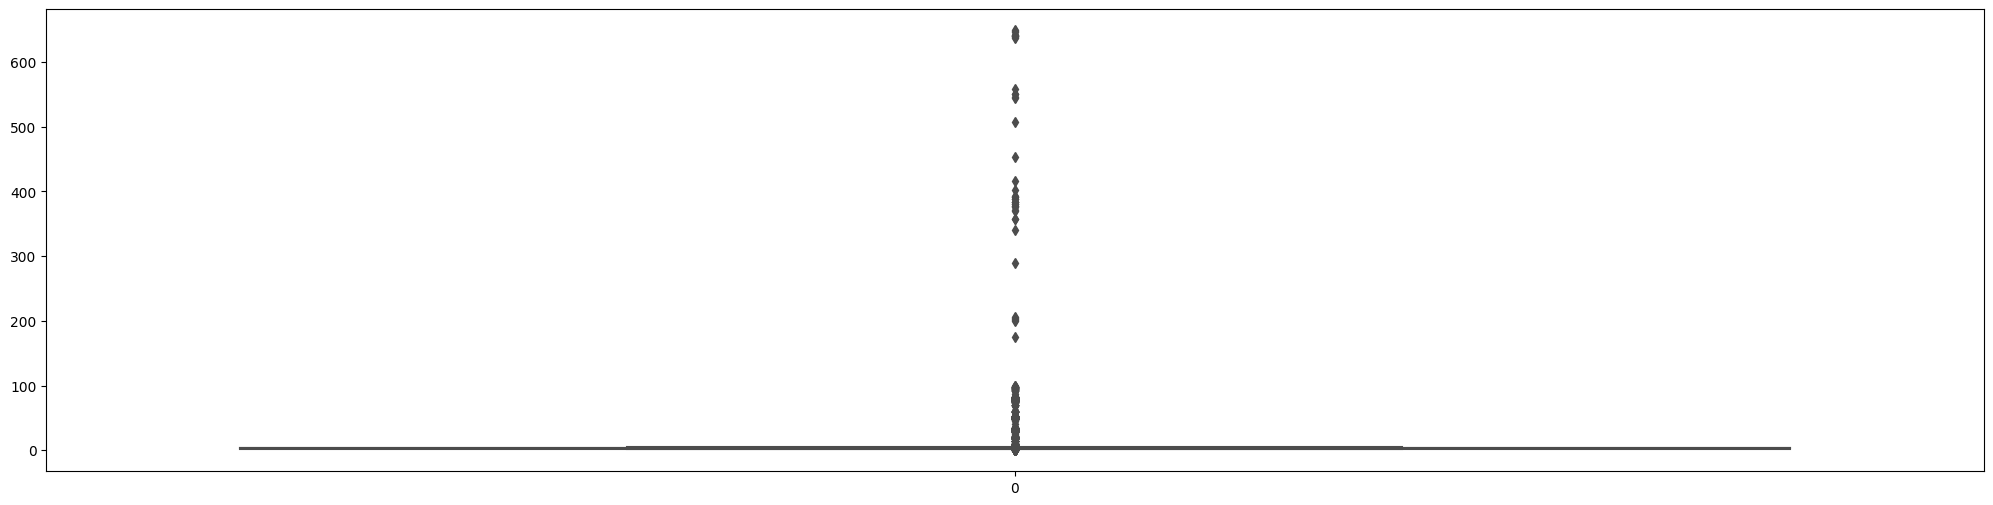

In [72]:
plt.figure(figsize=(25,6))
sns.boxplot(data=dam['outflow'], color='red')
plt.show()

In [73]:
#remove outlier

Q1 = dam['outflow'].quantile(0.25)
Q3 = dam['outflow'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range.

filter = (dam['outflow'] >= Q1 - 1.5 * IQR) & (dam['outflow'] <= Q3 + 1.5 *IQR)
dam = dam.loc[filter]
print(dam['outflow'].describe())
print('\n')
print(dam['outflow'].describe())

count    73071.000000
mean         3.053845
std          0.520811
min          1.700000
25%          2.700000
50%          3.100000
75%          3.400000
max          4.400000
Name: outflow, dtype: float64


count    73071.000000
mean         3.053845
std          0.520811
min          1.700000
25%          2.700000
50%          3.100000
75%          3.400000
max          4.400000
Name: outflow, dtype: float64


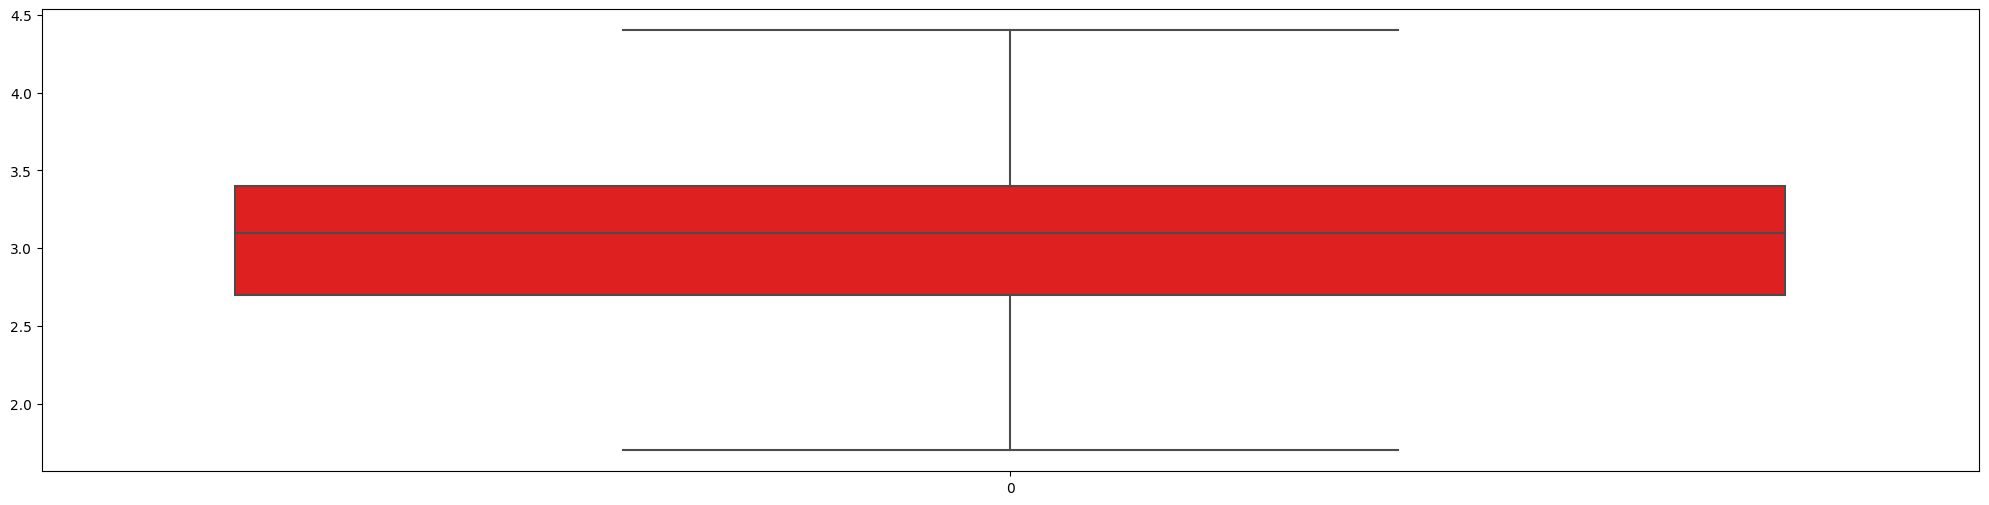

In [74]:
plt.figure(figsize=(25,6))
sns.boxplot(data=dam['outflow'], color='red')
plt.show()

In [75]:
dam = dam.reset_index(drop=True)

In [76]:
# ~시 -> ~:00으로 바꿔야 함, 24:00 -> 다음날 00:00으로 바꿔야 함
dam['date'] = dam['date'].str.replace('시', ':00')
data = dam['date']
print(data)

0        2015-01-01 01:00 
1        2015-01-01 02:00 
2        2015-01-01 03:00 
3        2015-01-01 04:00 
4        2015-01-01 05:00 
               ...        
73066    2023-07-17 03:00 
73067    2023-07-17 04:00 
73068    2023-07-17 05:00 
73069    2023-07-17 06:00 
73070    2023-07-17 07:00 
Name: date, Length: 73071, dtype: object


In [77]:
def convert(value):
    return str(value)

str_data = data.apply(convert)

changed_index = []
new_date = [] # 가공해서 넣을 date column list

# 시간 값이 24인 경우를 00:00:00으로 변경, 날짜 하루 더해줌.
for date in str_data:
    if " 24:" in date:
        temp = date.replace(" 24:", " 00:")
        new_date.append(pd.to_datetime(temp)+dt.timedelta(days=1))
    else: new_date.append(pd.to_datetime(date))

print(new_date[23]) # 2015-01-02 00:00:00
dam["date"] = new_date
dam.head()

2015-01-02 00:00:00


,date,water_level,rainfall,inflow,outflow,storage,storage_rate
0,2015-01-01 01:00:00,66.12,0.0,2.6,2.6,53.0,45.3
1,2015-01-01 02:00:00,66.12,0.0,3.0,3.0,53.0,45.3
2,2015-01-01 03:00:00,66.12,0.0,3.1,3.1,53.0,45.3
3,2015-01-01 04:00:00,66.12,0.0,3.0,3.0,53.0,45.3
4,2015-01-01 05:00:00,66.12,0.0,2.9,2.9,53.0,45.3


In [78]:
dam["date"] = pd.to_datetime(dam["date"])
dam.index = dam["date"]

In [79]:
dam.head()

,date,water_level,rainfall,inflow,outflow,storage,storage_rate
date,,,,,,,
2015-01-01 01:00:00,2015-01-01 01:00:00,66.12,0.0,2.6,2.6,53.0,45.3
2015-01-01 02:00:00,2015-01-01 02:00:00,66.12,0.0,3.0,3.0,53.0,45.3
2015-01-01 03:00:00,2015-01-01 03:00:00,66.12,0.0,3.1,3.1,53.0,45.3
2015-01-01 04:00:00,2015-01-01 04:00:00,66.12,0.0,3.0,3.0,53.0,45.3
2015-01-01 05:00:00,2015-01-01 05:00:00,66.12,0.0,2.9,2.9,53.0,45.3


In [80]:
dam

,date,water_level,rainfall,inflow,outflow,storage,storage_rate
date,,,,,,,
2015-01-01 01:00:00,2015-01-01 01:00:00,66.12,0.0,2.6,2.6,53.00,45.3
2015-01-01 02:00:00,2015-01-01 02:00:00,66.12,0.0,3.0,3.0,53.00,45.3
2015-01-01 03:00:00,2015-01-01 03:00:00,66.12,0.0,3.1,3.1,53.00,45.3
2015-01-01 04:00:00,2015-01-01 04:00:00,66.12,0.0,3.0,3.0,53.00,45.3
2015-01-01 05:00:00,2015-01-01 05:00:00,66.12,0.0,2.9,2.9,53.00,45.3
...,...,...,...,...,...,...,...
2023-07-17 03:00:00,2023-07-17 03:00:00,69.66,0.0,31.7,3.6,66.28,56.7
2023-07-17 04:00:00,2023-07-17 04:00:00,69.68,0.3,32.0,3.8,66.38,56.8
2023-07-17 05:00:00,2023-07-17 05:00:00,69.70,1.0,29.5,3.9,66.48,56.9


In [81]:
features = dam[['rainfall', 'inflow', 'outflow', 'storage', 'storage_rate']]
print(features)

                     rainfall  inflow  outflow  storage  storage_rate
date                                                                 
2015-01-01 01:00:00       0.0     2.6      2.6    53.00          45.3
2015-01-01 02:00:00       0.0     3.0      3.0    53.00          45.3
2015-01-01 03:00:00       0.0     3.1      3.1    53.00          45.3
2015-01-01 04:00:00       0.0     3.0      3.0    53.00          45.3
2015-01-01 05:00:00       0.0     2.9      2.9    53.00          45.3
...                       ...     ...      ...      ...           ...
2023-07-17 03:00:00       0.0    31.7      3.6    66.28          56.7
2023-07-17 04:00:00       0.3    32.0      3.8    66.38          56.8
2023-07-17 05:00:00       1.0    29.5      3.9    66.48          56.9
2023-07-17 06:00:00       2.0    32.1      3.9    66.58          57.0
2023-07-17 07:00:00       3.6    32.2      3.9    66.68          57.0

[73071 rows x 5 columns]


In [82]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
scaler.fit(features)
dam_scaled=scaler.transform(features)

dam_scaled=pd.DataFrame(data=dam_scaled, columns=list(features))
print('feature 최솟값')
print(dam_scaled.min())
print('\n''fearure 최댓값')
print(dam_scaled.max())

feature 최솟값
rainfall        0.0
inflow          0.0
outflow         0.0
storage         0.0
storage_rate    0.0
dtype: float64

fearure 최댓값
rainfall        1.0
inflow          1.0
outflow         1.0
storage         1.0
storage_rate    1.0
dtype: float64


In [83]:
dam['variation'] = 0
for i, idx in enumerate(dam.index):
    dam.loc[idx, 'variation'] = dam_scaled['rainfall'][i]+dam_scaled['inflow'][i]-dam_scaled['outflow'][i]

In [84]:
dam_scaled

,rainfall,inflow,outflow,storage,storage_rate
0,0.000000,0.003025,0.333333,0.561010,0.560606
1,0.000000,0.003490,0.481481,0.561010,0.560606
2,0.000000,0.003607,0.518519,0.561010,0.560606
3,0.000000,0.003490,0.481481,0.561010,0.560606
4,0.000000,0.003374,0.444444,0.561010,0.560606
...,...,...,...,...,...
73066,0.000000,0.036882,0.703704,0.733031,0.733333
73067,0.006329,0.037231,0.777778,0.734326,0.734848
73068,0.021097,0.034322,0.814815,0.735622,0.736364
73069,0.042194,0.037347,0.814815,0.736917,0.737879


In [85]:
dam = dam.reset_index(drop=True)

In [86]:
df = dam['variation']
df

0       -0.330308
1       -0.477991
2       -0.514912
3       -0.477991
4       -0.441070
           ...   
73066   -0.666822
73067   -0.734218
73068   -0.759395
73069   -0.735273
73070   -0.701402
Name: variation, Length: 73071, dtype: float64

In [87]:
ds_list = []

for i in range(1,len(df)):
    ds = df[i]-df[i-1]
    ds_list.append(ds)

ds_dt = pd.DataFrame(ds_list)

In [88]:
ds_dt.columns = ['ds_dt']
print(ds_dt)

          ds_dt
0     -0.147683
1     -0.036921
2      0.036921
3      0.036921
4      0.036921
...         ...
73065  0.000465
73066 -0.067396
73067 -0.025178
73068  0.024122
73069  0.033872

[73070 rows x 1 columns]


In [89]:
ds_dt['ds_dt'] = pd.to_numeric(ds_dt['ds_dt'],errors='coerce')
print(ds_dt)

          ds_dt
0     -0.147683
1     -0.036921
2      0.036921
3      0.036921
4      0.036921
...         ...
73065  0.000465
73066 -0.067396
73067 -0.025178
73068  0.024122
73069  0.033872

[73070 rows x 1 columns]


In [90]:
dam = dam[1:]

In [91]:
dam_scaled = dam_scaled[1:]

In [92]:
dam = dam.reset_index(drop=True)
print(dam)

                     date  water_level  rainfall  inflow  outflow  storage  \
0     2015-01-01 02:00:00        66.12       0.0     3.0      3.0    53.00   
1     2015-01-01 03:00:00        66.12       0.0     3.1      3.1    53.00   
2     2015-01-01 04:00:00        66.12       0.0     3.0      3.0    53.00   
3     2015-01-01 05:00:00        66.12       0.0     2.9      2.9    53.00   
4     2015-01-01 06:00:00        66.12       0.0     2.8      2.8    53.00   
...                   ...          ...       ...     ...      ...      ...   
73065 2023-07-17 03:00:00        69.66       0.0    31.7      3.6    66.28   
73066 2023-07-17 04:00:00        69.68       0.3    32.0      3.8    66.38   
73067 2023-07-17 05:00:00        69.70       1.0    29.5      3.9    66.48   
73068 2023-07-17 06:00:00        69.72       2.0    32.1      3.9    66.58   
73069 2023-07-17 07:00:00        69.74       3.6    32.2      3.9    66.68   

       storage_rate  variation  
0              45.3  -0.477991

In [93]:
dam_scaled = dam_scaled.reset_index(drop=True)
print(dam_scaled)

       rainfall    inflow   outflow   storage  storage_rate
0      0.000000  0.003490  0.481481  0.561010      0.560606
1      0.000000  0.003607  0.518519  0.561010      0.560606
2      0.000000  0.003490  0.481481  0.561010      0.560606
3      0.000000  0.003374  0.444444  0.561010      0.560606
4      0.000000  0.003258  0.407407  0.561010      0.560606
...         ...       ...       ...       ...           ...
73065  0.000000  0.036882  0.703704  0.733031      0.733333
73066  0.006329  0.037231  0.777778  0.734326      0.734848
73067  0.021097  0.034322  0.814815  0.735622      0.736364
73068  0.042194  0.037347  0.814815  0.736917      0.737879
73069  0.075949  0.037464  0.814815  0.738212      0.737879

[73070 rows x 5 columns]


In [94]:
dam['ds_dt'] = ds_dt

In [95]:
dam_scaled['ds_dt'] = ds_dt
dam_scaled['obs_storage_rate'] = dam['storage_rate']

In [96]:
print(dam)

                     date  water_level  rainfall  inflow  outflow  storage  \
0     2015-01-01 02:00:00        66.12       0.0     3.0      3.0    53.00   
1     2015-01-01 03:00:00        66.12       0.0     3.1      3.1    53.00   
2     2015-01-01 04:00:00        66.12       0.0     3.0      3.0    53.00   
3     2015-01-01 05:00:00        66.12       0.0     2.9      2.9    53.00   
4     2015-01-01 06:00:00        66.12       0.0     2.8      2.8    53.00   
...                   ...          ...       ...     ...      ...      ...   
73065 2023-07-17 03:00:00        69.66       0.0    31.7      3.6    66.28   
73066 2023-07-17 04:00:00        69.68       0.3    32.0      3.8    66.38   
73067 2023-07-17 05:00:00        69.70       1.0    29.5      3.9    66.48   
73068 2023-07-17 06:00:00        69.72       2.0    32.1      3.9    66.58   
73069 2023-07-17 07:00:00        69.74       3.6    32.2      3.9    66.68   

       storage_rate  variation     ds_dt  
0              45.3 

In [97]:
print(dam_scaled)

       rainfall    inflow   outflow   storage  storage_rate     ds_dt  \
0      0.000000  0.003490  0.481481  0.561010      0.560606 -0.147683   
1      0.000000  0.003607  0.518519  0.561010      0.560606 -0.036921   
2      0.000000  0.003490  0.481481  0.561010      0.560606  0.036921   
3      0.000000  0.003374  0.444444  0.561010      0.560606  0.036921   
4      0.000000  0.003258  0.407407  0.561010      0.560606  0.036921   
...         ...       ...       ...       ...           ...       ...   
73065  0.000000  0.036882  0.703704  0.733031      0.733333  0.000465   
73066  0.006329  0.037231  0.777778  0.734326      0.734848 -0.067396   
73067  0.021097  0.034322  0.814815  0.735622      0.736364 -0.025178   
73068  0.042194  0.037347  0.814815  0.736917      0.737879  0.024122   
73069  0.075949  0.037464  0.814815  0.738212      0.737879  0.033872   

       obs_storage_rate  
0                  45.3  
1                  45.3  
2                  45.3  
3                  

In [98]:
dam_scaled.insert(0, 'date', dam['date'])

In [99]:
dam_scaled["date"] = pd.to_datetime(dam_scaled["date"])

In [100]:
dam_scaled

,date,rainfall,inflow,outflow,storage,storage_rate,ds_dt,obs_storage_rate
0,2015-01-01 02:00:00,0.000000,0.003490,0.481481,0.561010,0.560606,-0.147683,45.3
1,2015-01-01 03:00:00,0.000000,0.003607,0.518519,0.561010,0.560606,-0.036921,45.3
2,2015-01-01 04:00:00,0.000000,0.003490,0.481481,0.561010,0.560606,0.036921,45.3
3,2015-01-01 05:00:00,0.000000,0.003374,0.444444,0.561010,0.560606,0.036921,45.3
4,2015-01-01 06:00:00,0.000000,0.003258,0.407407,0.561010,0.560606,0.036921,45.3
...,...,...,...,...,...,...,...,...
73065,2023-07-17 03:00:00,0.000000,0.036882,0.703704,0.733031,0.733333,0.000465,56.7
73066,2023-07-17 04:00:00,0.006329,0.037231,0.777778,0.734326,0.734848,-0.067396,56.8
73067,2023-07-17 05:00:00,0.021097,0.034322,0.814815,0.735622,0.736364,-0.025178,56.9
73068,2023-07-17 06:00:00,0.042194,0.037347,0.814815,0.736917,0.737879,0.024122,57.0


In [101]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [102]:
# 2. SMAPE 함수 정의
def smape(A, F):
    return 100 * np.mean(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [103]:
# 3. 데이터 준비 및 처리

# 가정: dam_scaled는 이미 정의된 DataFrame이며, 필요한 column들이 존재합니다.
features = ["rainfall", "inflow", "outflow", "ds_dt"]
output = "obs_storage_rate"

In [104]:
X = dam_scaled[features]
y = dam_scaled[output]

In [105]:
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [106]:
# 가정: dam_scaled에 'date'라는 이름의 날짜 column이 있습니다.
prophet_data_train = dam_scaled[['date', 'obs_storage_rate']][:split_index]
prophet_data_test = dam_scaled[['date', 'obs_storage_rate']][split_index:]

prophet_data_train.columns = ['ds', 'y']
prophet_data_test.columns = ['ds', 'y']

In [107]:
print(X_test.shape)

(14614, 4)


### obs_storage_rate만 사용했을 때

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb63us6jh/smou3die.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb63us6jh/veg8rpqm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35599', 'data', 'file=/tmp/tmpb63us6jh/smou3die.json', 'init=/tmp/tmpb63us6jh/veg8rpqm.json', 'output', 'file=/tmp/tmpb63us6jh/prophet_modeluz9n2ikk/prophet_model-20230809180021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb63us6jh/ojfrgeku.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb63us6jh/noqzxoim.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Best changepoint_prior_scale: 0.01
SMAPE for Prophet with best scale: 190.6893635577263


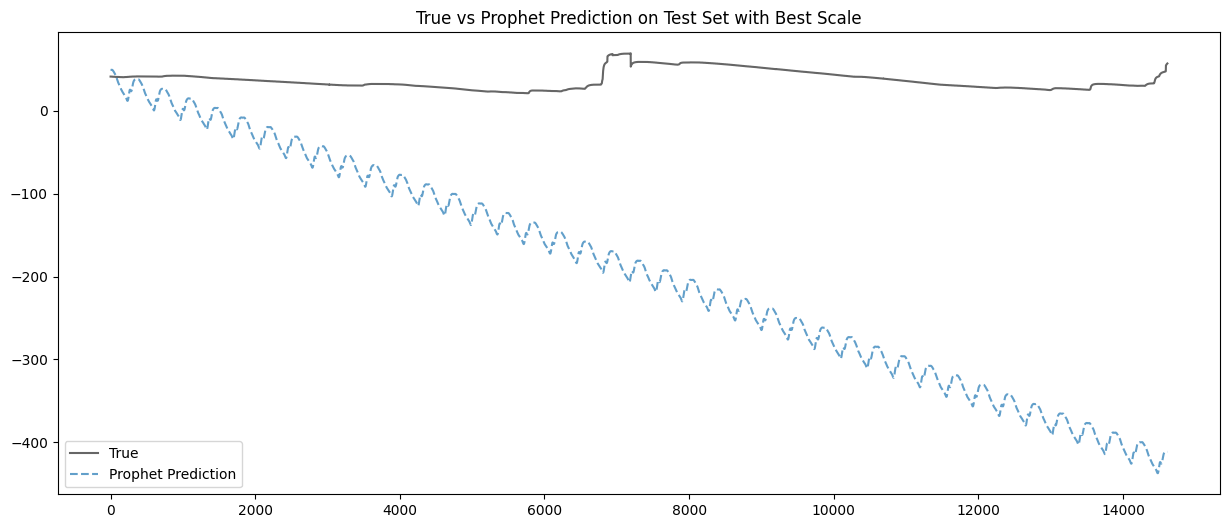

In [108]:
# 가정: dam_scaled에 'date'라는 이름의 날짜 column이 있습니다.
prophet_data_train = dam_scaled[['date', 'obs_storage_rate']][:split_index]
prophet_data_test = dam_scaled[['date', 'obs_storage_rate']][split_index:]

prophet_data_train.columns = ['ds', 'y']
prophet_data_test.columns = ['ds', 'y']

from prophet import Prophet

# 후보 changepoint_prior_scale 값들 정의
candidate_scales = [0.01,0.02,0.03,0.04,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
best_smape = float('inf')
best_scale = 0.1  # 초기값 설정

# Grid search 수행
for scale in candidate_scales:
    # Prophet 모델 초기화 및 학습
    model = Prophet(changepoint_prior_scale=scale, daily_seasonality = True)
    model.fit(prophet_data_train)

    # 미래 데이터 프레임 생성 및 예측
    future = model.make_future_dataframe(periods=len(prophet_data_test))
    forecast = model.predict(future)
    y_pred = forecast['yhat'][split_index:].values

    # SMAPE 계산
    current_smape = smape(prophet_data_test['y'], y_pred)
    if current_smape < best_smape:
        best_smape = current_smape
        best_scale = scale

# 최적의 changepoint_prior_scale 값으로 모델 초기화 및 학습
model_prophet = Prophet(changepoint_prior_scale=best_scale)
model_prophet.fit(prophet_data_train)

# 미래 데이터 프레임 생성 및 예측
future = model_prophet.make_future_dataframe(periods=len(prophet_data_test))
forecast = model_prophet.predict(future)
y_pred_prophet = forecast['yhat'][split_index:].values

# 결과 출력
print(f"Best changepoint_prior_scale: {best_scale}")
print(f"SMAPE for Prophet with best scale: {best_smape}")

# 그래프로 표현
plt.figure(figsize=(15, 6))
plt.plot(prophet_data_test['y'].values, label='True', color='black', alpha=0.6)
plt.plot(y_pred_prophet, label='Prophet Prediction', linestyle='dashed', alpha=0.7)
plt.title("True vs Prophet Prediction on Test Set with Best Scale")
plt.legend()
plt.show()

### Multivariable features

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb63us6jh/h_ba_gfd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb63us6jh/90s1h6fq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19482', 'data', 'file=/tmp/tmpb63us6jh/h_ba_gfd.json', 'init=/tmp/tmpb63us6jh/90s1h6fq.json', 'output', 'file=/tmp/tmpb63us6jh/prophet_modelr0ggmy7f/prophet_model-20230809182752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb63us6jh/m3rpg8z4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb63us6jh/8a7rbrg2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Best changepoint_prior_scale: 0.001
SMAPE for Prophet with best scale: 21.04885392150109


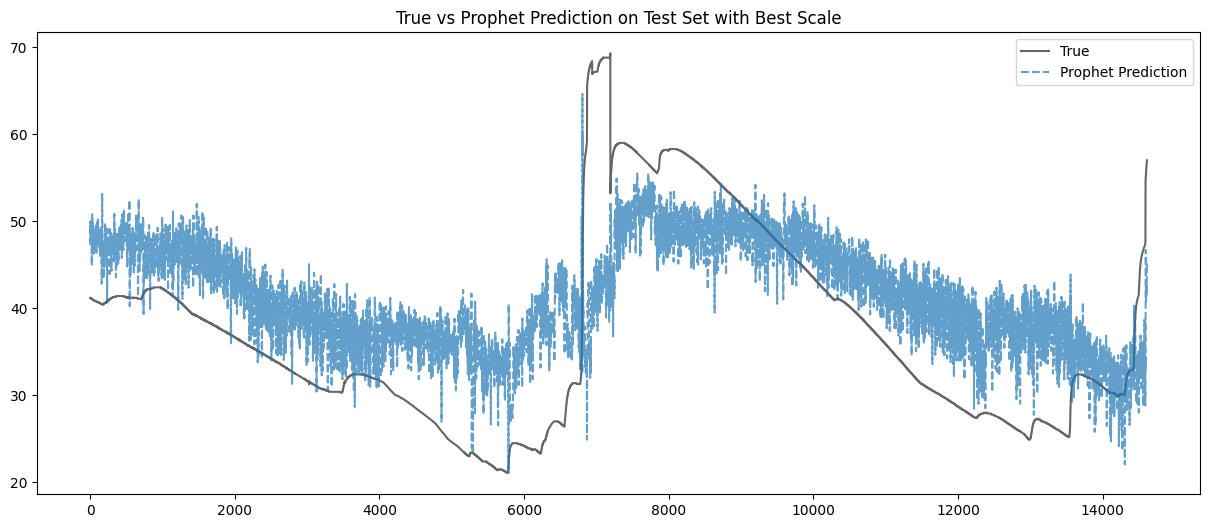

In [109]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# train, test 데이터 준비
prophet_data_train = dam_scaled[['date', 'obs_storage_rate']][:split_index]
prophet_data_test = dam_scaled[['date', 'obs_storage_rate']][split_index:]

prophet_data_train.columns = ['ds', 'y']
prophet_data_test.columns = ['ds', 'y']

# 기타 feature들을 train과 test 데이터셋에 추가
for col in dam_scaled.columns:
    if col not in ['date', 'obs_storage_rate', 'storage_rate', 'storage']:
        prophet_data_train[col] = dam_scaled[col][:split_index]
        prophet_data_test[col] = dam_scaled[col][split_index:]

# 후보 changepoint_prior_scale 값들 정의 및 초기 설정
candidate_scales = [0.001,0.005,0.0075, 0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
best_smape = float('inf')
best_scale = 0.1

for scale in candidate_scales:
    model = Prophet(changepoint_prior_scale=scale, daily_seasonality=True)

    # 추가적인 feature들을 Prophet 모델에 추가
    for col in dam_scaled.columns:
        if col not in ['date', 'obs_storage_rate', 'storage_rate', 'storage']:
            model.add_regressor(col)

    model.fit(prophet_data_train)

    # 예측을 위한 future 데이터 프레임 생성
    future_with_features = prophet_data_test.drop('y', axis=1)

    # 예측
    forecast = model.predict(future_with_features)
    y_pred = forecast['yhat'].values

    # SMAPE 계산
    current_smape = smape(prophet_data_test['y'], y_pred)
    if current_smape < best_smape:
        best_smape = current_smape
        best_scale = scale

# 최적의 changepoint_prior_scale로 모델 학습
model_prophet = Prophet(changepoint_prior_scale=best_scale)
for col in dam_scaled.columns:
    if col not in ['date', 'obs_storage_rate', 'storage_rate', 'storage']:
        model_prophet.add_regressor(col)
model_prophet.fit(prophet_data_train)

# 예측을 위한 future 데이터 프레임 생성
future_with_features = prophet_data_test.drop('y', axis=1)

# 예측
forecast = model_prophet.predict(future_with_features)
y_pred_prophet = forecast['yhat'].values

# 결과 출력 및 그래프 표현
print(f"Best changepoint_prior_scale: {best_scale}")
print(f"SMAPE for Prophet with best scale: {best_smape}")

plt.figure(figsize=(15, 6))
plt.plot(prophet_data_test['y'].values, label='True', color='black', alpha=0.6)
plt.plot(y_pred_prophet, label='Prophet Prediction', linestyle='dashed', alpha=0.7)
plt.title("True vs Prophet Prediction on Test Set with Best Scale")
plt.legend()
plt.show()


In [145]:
alphas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
best_smape_ewm = float('inf')
best_alpha = None

for alpha in alphas:
    y_pred_ewm = pd.Series(y_pred_prophet).ewm(alpha=alpha).mean().values
    current_smape_ewm = smape(prophet_data_test['y'].values, y_pred_ewm)

    if current_smape_ewm < best_smape_ewm:
        best_smape_ewm = current_smape_ewm
        best_alpha = alpha

print(f"Best alpha: {best_alpha}")
print(f"SMAPE for EWMA Prophet Prediction with best alpha: {best_smape_ewm}")

Best alpha: 0.1
SMAPE for EWMA Prophet Prediction with best alpha: 19.84885392079484


SMAPE for Prophet with best scale: 19.84885392079484


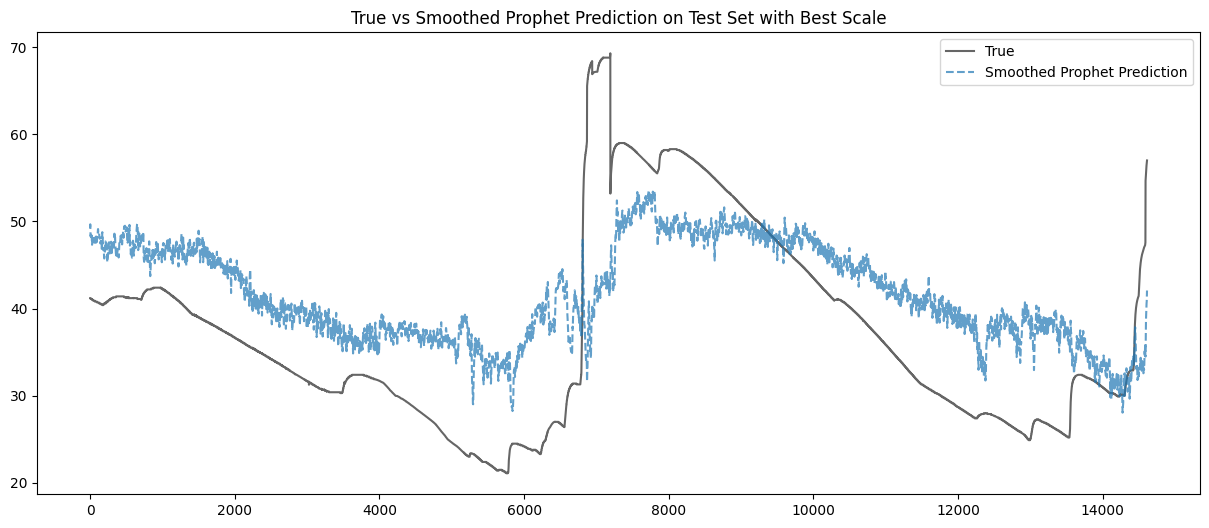

In [146]:
alpha = best_alpha # 지수 가중치. 0과 1 사이의 값을 가집니다. 값이 작을수록 평활화 정도가 커집니다.

y_pred_ewm = pd.Series(y_pred_prophet).ewm(alpha=alpha).mean().values

smape_ewm = smape(prophet_data_test['y'].values, y_pred_ewm)

# 결과 출력 및 그래프 표현
print(f"SMAPE for Prophet with best scale: {smape_ewm}")

plt.figure(figsize=(15, 6))
plt.plot(prophet_data_test['y'].values, label='True', color='black', alpha=0.6)
plt.plot(y_pred_ewm, label='Smoothed Prophet Prediction', linestyle='dashed', alpha=0.7)
plt.title("True vs Smoothed Prophet Prediction on Test Set with Best Scale")
plt.legend()
plt.show()


In [131]:
alphas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
best_smape_ewm = float('inf')
best_alpha = None

for alpha in alphas:
    y_pred_ewm = pd.Series(y_pred_prophet).ewm(alpha=alpha).mean().values
    current_smape_ewm = smape(prophet_data_test['y'].values, y_pred_ewm)

    if current_smape_ewm < best_smape_ewm:
        best_smape_ewm = current_smape_ewm
        best_alpha = alpha

print(f"Best alpha: {best_alpha}")
print(f"SMAPE for EWMA Prophet Prediction with best alpha: {best_smape_ewm}")


Best alpha: 0.1
SMAPE for EWMA Prophet Prediction with best alpha: 19.84885392079484


In [117]:
from sklearn.metrics import mean_squared_error, r2_score

def smape(y_true, y_pred):
    return 100 * (2 * abs(y_pred - y_true).sum() / (abs(y_true).sum() + abs(y_pred).sum()))

def compute_rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def compute_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)


In [118]:
y_true = prophet_data_test['y'].values

rmse_value = compute_rmse(y_true, y_pred_prophet)
smape_value = smape(y_true, y_pred_prophet)
r2_value = compute_r2(y_true, y_pred_prophet)

print(f"RMSE: {rmse_value}")
print(f"SMAPE: {smape_value}")
print(f"R^2: {r2_value}")


RMSE: 9.282195013077555
SMAPE: 19.991547574278513
R^2: 0.3137550937081306


In [119]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [120]:
# 4. 각 모델 (XGBoost, LightGBM) 학습 후 예측

# XGBoost
xgb_model = XGBRegressor()
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_smape = smape(y_test, xgb_pred)

# LightGBM
lgbm_model = LGBMRegressor(verbose=-1)
lgbm_model.fit(X_train_scaled, y_train)
lgbm_pred = lgbm_model.predict(X_test_scaled)
lgbm_smape = smape(y_test, lgbm_pred)


# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_smape = smape(y_test, rf_pred)


print(f"SMAPE for XGBoost: {xgb_smape}")
print(f"SMAPE for LightGBM: {lgbm_smape}")
print(f"SMAPE for RandomForest: {rf_smape}")

SMAPE for XGBoost: 27.500603085349773
SMAPE for LightGBM: 26.95190123594962
SMAPE for RandomForest: 28.187548395423573


In [121]:
# xgboost와 Prophet의 예측을 가중 평균하여 앙상블
# 가중치는 각 모델의 SMAPE의 역수로 설정
xgb_weight = 1 / xgb_smape
prophet_weight = 1 / best_smape

ensemble_pred = (xgb_pred * xgb_weight + y_pred_prophet * prophet_weight) / (xgb_weight + prophet_weight)
ensemble_smape = smape(y_test, ensemble_pred)

print(f"SMAPE for xgboost: {xgb_smape}")
print(f"SMAPE for Prophet: {best_smape}")
print(f"SMAPE for Ensemble: {ensemble_smape}")

SMAPE for xgboost: 27.500603085349773
SMAPE for Prophet: 21.04885392150109
SMAPE for Ensemble: 22.684330948177248


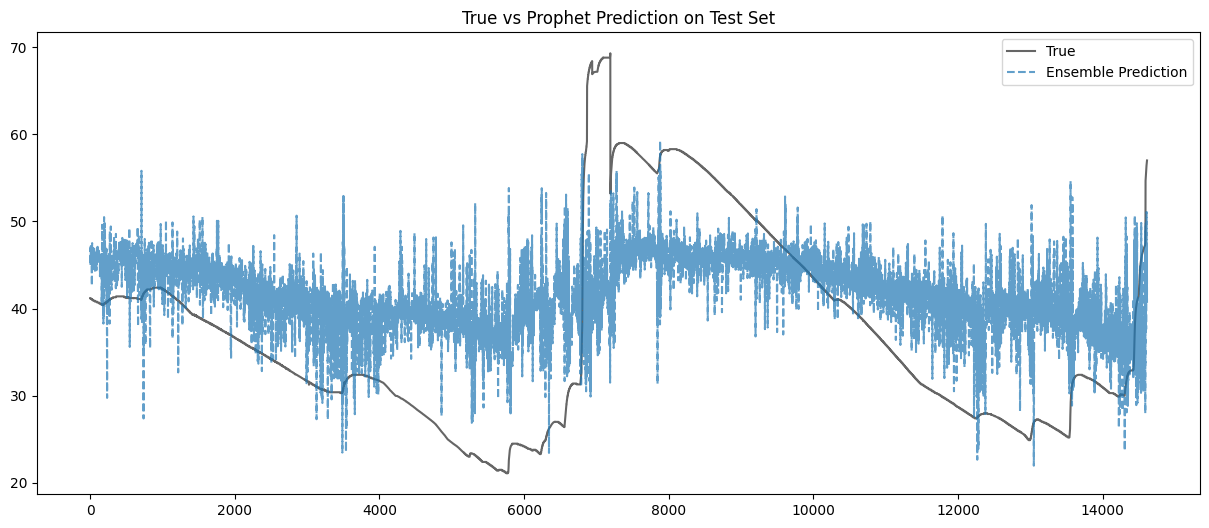

In [122]:
# 그래프로 표현
plt.figure(figsize=(15, 6))
plt.plot(prophet_data_test['y'].values, label='True', color='black', alpha=0.6)
plt.plot(ensemble_pred, label='Ensemble Prediction', linestyle='dashed', alpha=0.7)
plt.title("True vs Prophet Prediction on Test Set")
plt.legend()
plt.show()

In [123]:
y_true = prophet_data_test['y'].values

rmse_value = compute_rmse(y_true, ensemble_pred)
smape_value = smape(y_true, ensemble_pred)
r2_value = compute_r2(y_true, ensemble_pred)

print(f"RMSE: {rmse_value}")
print(f"SMAPE: {smape_value}")
print(f"R^2: {r2_value}")


RMSE: 10.414883195790344
SMAPE: 22.684330948177248
R^2: 0.13605406747266058
